In [1]:
using Pkg
# Pkg.activate("/media/mat/HDD/EnKF/")
Pkg.activate("/media/mat/HDD/VortexModels/")

Activating environment at `/media/mat/HDD/VortexModels/Project.toml`


In [2]:
using PotentialFlow
import PotentialFlow.Utils: @get

┌ Info: Precompiling PotentialFlow [73af2aaf-3f58-5b29-82a9-435ecf827f5b]
└ @ Base loading.jl:1242


In [3]:
using Revise
using ProgressMeter
using LinearAlgebra
using Statistics
# using PlotUtils

In [4]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
clibrary(:colorbrewer)
pyplot()

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1242
┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1242


Plots.PyPlotBackend()

In [5]:
# if !Plots.is_installed("PyPlot")
#     Pkg.add("PyPlot")
# end
# withenv("PYTHON" => "") do
#     Pkg.build("PyPlot")
# end

## Load CFD Data

In [6]:
using FileIO
using Interpolations

In [7]:
# re500_data = load(expanduser("/home/matmat/Documents/PhD/VortexModel/DarwinVortex/data/re500_aoa20.jld2")) # No Pulse
# re500_data = load(expanduser("~/Documents/Research/data/rey500_pulse01_data.jld2"))
re500_data = load(expanduser("/media/mat/HDD/VortexModels/data/rey500_aoa20_2pulse01_data.jld2"))

Dict{String,Any} with 6 entries:
  "pressure"  => Dict{String,Any}("t"=>0.05:0.05:10.0,"edges"=>(-0.5, 0.5),"s"=…
  "Re"        => 500
  "aoa"       => 0.349066
  "force"     => Dict{String,Any}("t"=>0.001:0.001:10.0,"F"=>Complex{Float64}[-…
  "vorticity" => Dict{String,Any}("x"=>[-0.996, -0.992, -0.988, -0.984, -0.98, …
  "actuation" => ((3.0, 4.0), 0.01)

In [8]:
## Old version 0.6
# pressure_data = let pressure = -re500_data["pressure"]["p"],
#     T = re500_data["pressure"]["t"],
#     s = re500_data["pressure"]["s"],
#     le = re500_data["pressure"]["edges"][1]
    
    
#     scale(interpolate(pressure, BSpline(Cubic(Line())), OnGrid()), sign(le)*s, T)
# end;

In [9]:
pressure_data = let pressure = -re500_data["pressure"]["p"],
    T = re500_data["pressure"]["t"],
    s = re500_data["pressure"]["s"],
    le = re500_data["pressure"]["edges"][1]
    
#     scale(interpolate(reverse(pressure, dims = 1), BSpline(Cubic(Line(OnGrid())))), 
#         reverse(sign(le)*s, dims = 1), T, extrapolation  = Flat())
    CubicSplineInterpolation((reverse(sign(le)*s), T),reverse(pressure, dims = 1), extrapolation_bc =  Line())
end;

In [10]:
pressure_data(-0.4,0.0)

-0.23260800496897818

In [11]:
pressure_data(0.1,2.0)

-1.1639155392089846

In [12]:
function cfd_pressure(t, taps, config, pressure_data)
    s = [-0.5config.L*cos(n*π/(config.N-1)) for n in taps]
    [pressure_data(i,t) for i in s]
end

cfd_pressure (generic function with 1 method)

In [13]:
struct Config
    N::Int
    L::Float64
    ċ::ComplexF64
    α::Float64
    δ::Float64
    Δt::Float64
    transfer::Bool
end
config = let N = 512, L = 1.0, ċ = 1.0,
             α = π/9, δ = 5e-3, Δt = 1e-2

    Config(N, L, ċ, α, δ, Δt, true)
end

Config(512, 1.0, 1.0 + 0.0im, 0.3490658503988659, 0.005, 0.01, true)

In [14]:
tf = 5.0
pressure_taps = 10:10:config.N-10
T = 0:config.Δt:tf

0.0:0.01:5.0

In [15]:
using ColorSchemes

In [16]:
ColorSchemes.lighttemperaturemap

In [17]:
reverse(ColorSchemes.RdYlBu_9)

In [18]:
reverse(ColorSchemes.rainbow)

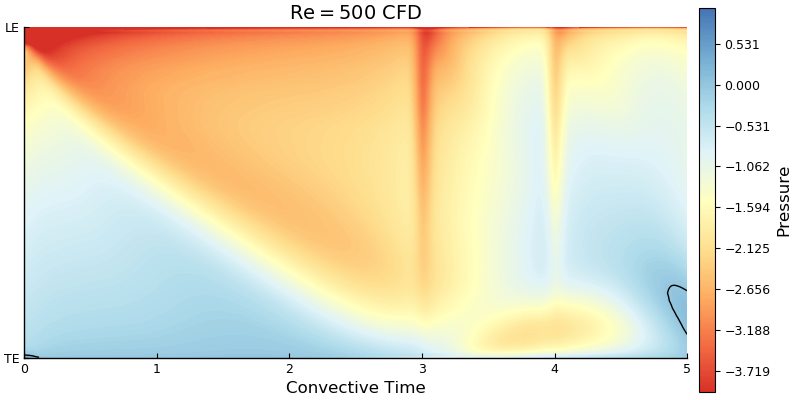

sys:1: UserWarning: The following kwargs were not used by contour: 'label'
findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.


In [19]:
sch = ColorSchemes.RdYlBu_9.colors
let s = [-0.5config.L*cos(θ) for θ in range(0.0, stop = π, length = config.N)][pressure_taps],
    #model_pressures = hcat((measure_state(mean(states[i+1]), t, config, pressure_taps) for (i,t) in enumerate(T))...),
    cfd_pressures = 2hcat((cfd_pressure(t, pressure_taps, config, pressure_data) for t in T)...)
        
    plt = plot(size = (800, 400))
    contourf!(T, s, cfd_pressures, title = ["\$\\mathrm{Re} = 500\$ CFD" "EnKF Mean"],
        levels = range(-4.0, stop = 1, length = 161), clims = (-4, 1), color = cgrad(sch), xlabel = "Convective Time",
        #levels = linspace(-2, 2, 151), clims = (-2, 0.5), color = cgrad(reverse(colormap(:rainbow))), xlabel = ["Convective Time"],
        yticks = ([0.5, -0.5], ["LE", "TE"]), background_color_inside = sch[1],colorbar_title="Pressure")
        #yticks = ([0.5, -0.5], ["LE", "TE"]), background_color_inside = colormap(:rainbow)[end], colorbar_title="Pressure")
    contour!(T, s, cfd_pressures,levels=0:0,seriescolor=:black)
end
# savefig("test1.pdf")
# savefig("EnKF\ Results/Re500/2pulse01/no_inflation/pressure_comparison.pdf")

## Model Formulation

We have a flat plate that is translating at a fixed angle of attack and velocity.
We also use a constant blob radius on all of our vortex elements

In [20]:
struct Config
    N::Int
    L::Float64
    ċ::ComplexF64
    α::Float64
    δ::Float64
    Δt::Float64
    transfer::Bool
end

In [21]:
# include("merging_model.jl")
include("/media/mat/HDD/VortexModels/SparseVortex/Jupyter notebooks/merging_model.jl")

regen_forces (generic function with 1 method)

In [22]:
config = let N = 512, L = 1.0, ċ = 1.0,
             α = π/9, δ = 5e-3, Δt = 1e-2

    Config(N, L, ċ, α, δ, Δt, true)
end
ensemble_size = 1 #50

lesp₀ = 0.5 #0.5
tesp₀ = 0.0
lesprand = 0.0 #0.1
lesps = clamp.(lesp₀ .+ lesprand*randn(ensemble_size), 0.0, 3.0);
tesps = tesp₀ .+ 0.0randn(ensemble_size);

states = [map((a,b) -> [a, b], lesps, tesps)];

In [23]:
states

1-element Array{Array{Array{Float64,1},1},1}:
 [[0.5, 0.0]]

In [24]:
states[1]

1-element Array{Array{Float64,1},1}:
 [0.5, 0.0]

In [25]:
# states = [[0.5569135495948161, 0.0]]
covs = [];

In [26]:
config

Config(512, 1.0, 1.0 + 0.0im, 0.3490658503988659, 0.005, 0.01, true)

In [27]:
tf = 60*config.Δt#15.0
pressure_taps = 10:10:config.N-10
T = 0:config.Δt:tf
ϵ = 1e-4
α = 1.01
isenkf = false
@showprogress for (n,t) in enumerate(T)
    push!(states, [])
    empty_inds = Vector{Int}[]
    len = Int[]
    
    # predicted_states (with merging)
    for (i, state) in enumerate(states[end-1])
        new_state = state_equation(state, t, config)
        new_blobs, lesp, tesp = state_to_blobs(new_state, config.δ)
        push!(empty_inds, findall(b -> circulation(b) == 0, new_blobs))
        push!(len, length(new_blobs))
        push!(states[end], new_state)
    end
    
    # trim zeros
    @assert all(len .== len[1])
    toremove = intersect(empty_inds...)
    tokeep = filter(i -> i ∉ toremove, 1:len[1])
    for (i, state) in enumerate(states[end])
        new_blobs, lesp, tesp = state_to_blobs(state, config.δ)
        states[end][i] = blobs_to_state(new_blobs[tokeep], lesp, tesp)
    end
#     mean_state = mean(states[end])
# #     @show t
# #     @show measure_state(states[end][1], t, config, pressure_taps)
    
# #     @show cfd_pressure(t+config.Δt, pressure_taps, config, pressure_data)
    
# #     Covariance inflation
#     if isenkf
#     for (j,x) in enumerate(states[end])
#         x .= mean_state .+ α*(x .- mean_state)
#         if n > 5
#         for i in 1:3:size(mean_state, 1)-3
#             x[i:i+1] .+= 1e-5*randn(2)
#             x[i+2]   += 1e-5*randn()
#         end
#                 x[end-1] = clamp(x[end-1] + 5e-5*randn(), 0.0, 3.0)
#         end
#     end
#     mean_state .= mean(states[end])
    
#     # Compute deviation from mean state
#     A′ = hcat(states[end]...)
#     A′ .-= mean_state

#     # compute measurements
#     P = [measure_state(s, t, config, pressure_taps) for s in states[end]]
    
#     # compute deviation from measurement of the mean
#     Â = hcat(P...)
#     Â′= Â .- measure_state(mean_state, t, config, pressure_taps)


#     # get actual measurements
#     D = repeat(cfd_pressure(t+config.Δt, pressure_taps, config, pressure_data), 1, ensemble_size)

#     # perturbe actual measurements
#     E = ϵ*randn(size(Â′))
#     D .+= E

#     b = ((Â′*Â′') + (ensemble_size-1)*(ϵ^2)*I) \ (D - Â)
#     Bᵀb = (A′*Â′')*b


#     for i in 1:ensemble_size
#         states[end][i] .+= Bᵀb[:,i]
#         states[end][i][end-1] = clamp(states[end][i][end-1], 0, 3)
#     end
    
#     mean_state .= mean(states[end])
#     # Compute deviation from mean state
#     A′ = hcat(states[end]...)
#     A′ .-= mean_state
#     push!(covs, A′*A′')
#     end

    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


In [29]:
states[40]

1-element Array{Array{Float64,1},1}:
 [0.6781346755873348, 0.1960893718670128, 0.14969103427689423, -0.3908689343133717, -0.1661373240844032, -0.324472169965975, -0.15810909263701672, -0.19468630160317077, -0.006184174789501239, -0.34401812476847105  …  -0.18231458925618205, -0.0053191448665830185, 0.8397923437423936, 0.18718702632863476, 0.014952825234014387, -0.098572515413195, -0.1785846818480516, -0.005126363391084707, 0.5, 0.0]

In [28]:
states[40]

1-element Array{Array{Float64,1},1}:
 [0.6781346755873356, 0.19608937186701308, 0.14969103427689423, -0.3908689343133717, -0.16613732408440307, -0.32447216996597505, -0.1581090926370165, -0.19468630160317077, -0.006184174789501239, -0.34401812476847116  …  -0.18231458925618202, -0.005319144866583031, 0.8397923437423936, 0.18718702632863476, 0.014952825234014339, -0.098572515413195, -0.1785846818480516, -0.0051263633910847185, 0.5, 0.0]

In [29]:
states[end][1]

59-element Array{Float64,1}:
  0.8244165771757285  
  0.12340899198428212 
  0.19479604308137524 
 -0.3073950401489362  
 -0.1901012221078943  
 -0.40581166652870354 
  0.06365136422412361 
 -0.194304558781417   
 -0.003990395454808145
 -0.25574126506629064 
 -0.14191123479848125 
 -0.1471227961653099  
  0.9041225381712659  
  ⋮                   
  0.011510378403555477
  0.11211685950620301 
 -0.18175462881129717 
 -0.004812038333712814
  1.0603181166354554  
  0.18711169747090067 
  0.011682377290932059
  0.12160401987245385 
 -0.1783858399088265  
 -0.003737033815360037
  0.5                 
  0.0                 

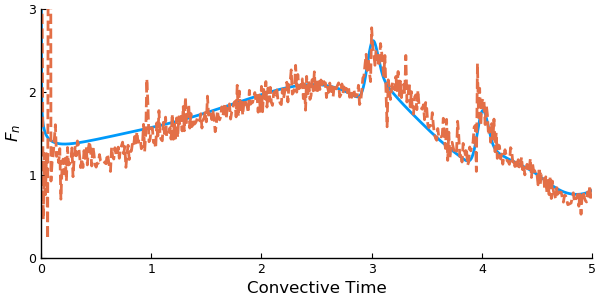

In [57]:
fn = regen_forces(T, mean.(states), config);
plot(re500_data["force"]["t"], abs.(re500_data["force"]["F"]), label = "\$\\mathrm{Re} = 500\$ CFD", xlim = (0,5),
legend = false, linewidth = 2)
plot!(T, 2abs.(fn)[1:end-1], ylim = (0, 3), label = "EnKF Mean", ylabel="\$F_n\$", xlabel = "Convective Time", size = (600, 300),
linewidth = 2, linestyle = :dash)
# savefig("EnKF\ Results/Re500/2pulse01/no_inflation/force.pdf")

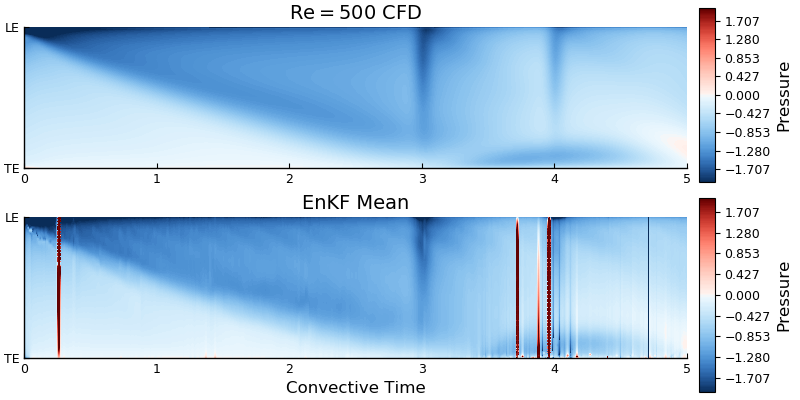

In [40]:
let s = [-0.5config.L*cos(θ) for θ in range(0.0, stop = π, length = config.N)][pressure_taps],
    model_pressures = hcat((measure_state(mean(states[i+1]), t, config, pressure_taps) for (i,t) in enumerate(T))...),
    cfd_pressures = hcat((cfd_pressure(t, pressure_taps, config, pressure_data) for t in T)...)
    
    plt = plot(layout = (2,1), size = (800, 400))
    contourf!(T, s, [cfd_pressures, model_pressures], title = ["\$\\mathrm{Re} = 500\$ CFD" "EnKF Mean"],
        levels = range(-2.0, stop  = 2.0, length = 151), clims = (-2, 2), color = cgrad(reverse(colormap("RdBu"))), xlabel = ["" "Convective Time"],
        yticks = ([0.5, -0.5], ["LE", "TE"]), background_color_inside = colormap("RdBu")[end], colorbar_title="Pressure")
end
# savefig("EnKF\ Results/Re500

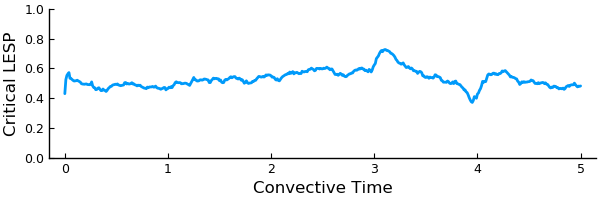

In [43]:
plot(T, [mean((x -> x[end-1]).(s)) for s in states[2:end]], legend = false,
    xlabel = "Convective Time", ylabel = "Critical LESP", linewidth = 2, size = (600, 200),
ylim = (0, 1))
# savefig("EnKF\ Results/Re500/2pulse01/no_inflation/lesp.pdf")

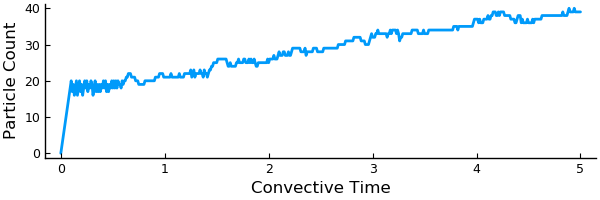

In [41]:
plot(T, [(length(s[1]) - 2) ÷ 3 for s in states[1:end-1]], linewidth = 2, size = (600, 200), legend = false,
xlabel = "Convective Time", ylabel="Particle Count")
# savefig("EnKF\ Results/Re500/2pulse01/no_inflation/particle_count.pdf")

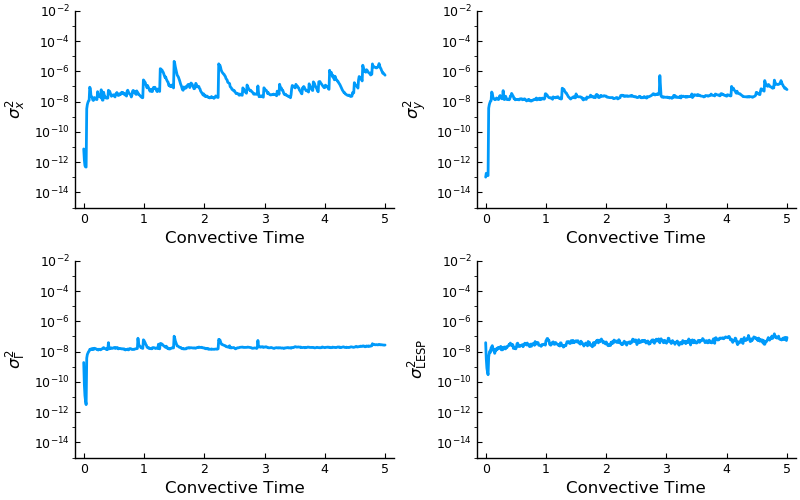

In [42]:
plt = plot(layout = (2,2), size = (800, 500), legend = false)
plot!(plt[1], T, map(covs) do P
        mean(diag(P)[1:3:end-3]) + eps()
        end, ylim = (1e-15, 1e-2), yscale = :log10, linewidth = 2, xlabel = "Convective Time",
ylabel = "\$\\sigma_x^2\$")
plot!(plt[2], T, map(covs) do P
        mean(diag(P)[2:3:end-3]) + eps()
        end, ylim = (1e-15, 1e-2), yscale = :log10, linewidth = 2, xlabel = "Convective Time",
ylabel = "\$\\sigma_y^2\$")
plot!(plt[3],T,  map(covs) do P
        mean(diag(P)[3:3:end-3]) + eps()
        end, ylim = (1e-15, 1e-2), yscale = :log10, linewidth = 2, xlabel = "Convective Time",
ylabel = "\$\\sigma_\\Gamma^2\$")
plot!(plt[4], T, map(covs) do P
        mean(diag(P)[end-1]) + eps()
        end, ylim = (1e-15, 1e-2), yscale = :log10, linewidth = 2, xlabel = "Convective Time",
ylabel = "\$\\sigma_\\mathrm{LESP}^2\$")
# savefig("EnKF\ Results/Re500/2pulse01/no_inflation/covariance.pdf")

### Snapshot Figures

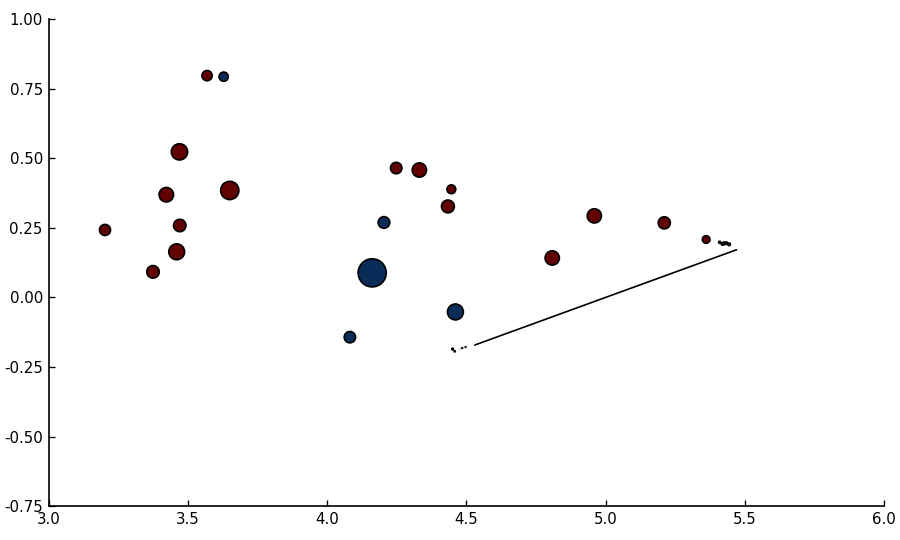

In [43]:
n = 500
# for n in [250, 300, 350, 400, 450, 500]
plt = plot(colorbar = :none, size = (750, 450), dpi = 120)
plot!(plt, Plate(config.N, config.L, config.Δt*n, config.α), ratio = 1, legend = false)
plot!(plt, state_to_blobs(mean(states[n]), config.δ)[1], markersize = 15sqrt.(abs.(mean(states[n])[3:3:end-2])), markerstrokealpha = 0, color = cgrad(reverse(colormap("RdBu"))), clim = (-0.02, 0.02), 
    ratio = 1, xlim = (n/100 - 2, n/100 + 1), ylim = (-0.75,1), xticks = (n/100 - 2):0.5:(n/100 + 1)
)
# savefig("EnKF\ Results/Re500/2pulse01/no_inflation/enkf_t$(lpad(n, 3, 0)).pdf")

# plt = plot(colorbar = :none, size = (750, 450), dpi = 120)
# contour!(plt, n/100 - re500_data["vorticity"]["x"], re500_data["vorticity"]["y"],
#     transpose(re500_data["vorticity"]["vorticity"][n÷5]), levels = linspace(-30, 30, 100),
#     color = :RdBu, clim = (-20, 20),
#     xlim = (n/100 - 2, n/100 + 1), ylim = (-0.75, 1), ratio = 1, legend = :none, xticks = (n/100 - 2):0.5:(n/100 + 1))
# savefig("EnKF\ Results/Re500/2pulse01/multiplicative_inflation/cfd_t$(lpad(n, 3, 0)).pdf")
# end

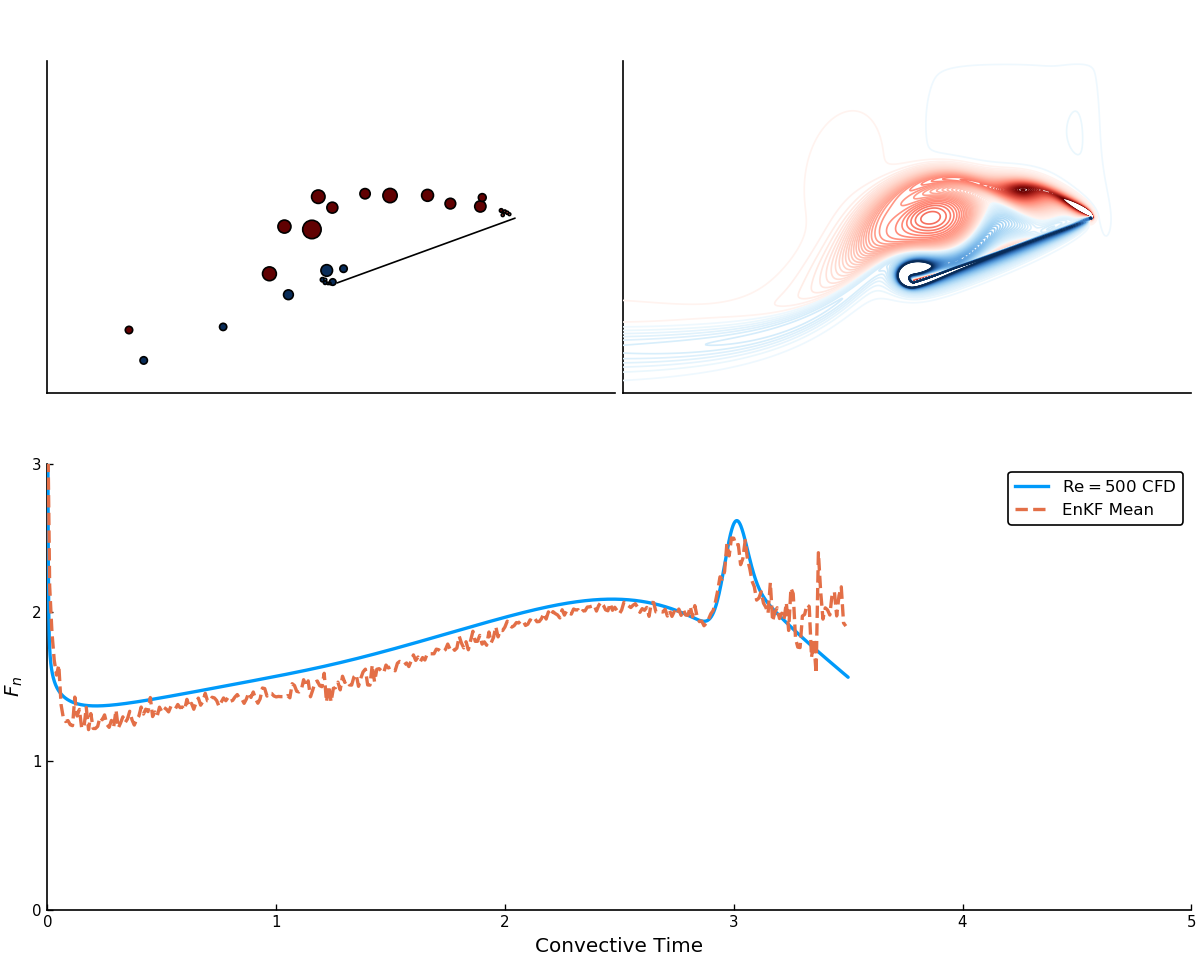

In [47]:
f = regen_forces(T, mean.(states), config);
n = 350
# @showprogress for (i,n) in enumerate(5:5:500)
l = @layout [  grid(1, 2)
               b{0.5h} ]

plt = plot(layout = l, colorbar = :none, size = (1000, 800), dpi = 120)
plot!(plt[1], Plate(config.N, config.L, config.Δt*n, config.α), ratio = 1, legend = false)
plot!(plt[1], state_to_blobs(mean(states[n]), config.δ)[1], markersize = 15sqrt.(abs.(mean(states[n])[3:3:end-2])), markerstrokealpha = 0, color = cgrad(reverse(colormap("RdBu"))), clim = (-0.02, 0.02), 
    ratio = 1, xlim = (n/100 - 2, n/100 + 1), ylim = (-0.75,1),
    xticks = [], yticks = [])
    contour!(plt[2], re500_data["vorticity"]["x"], re500_data["vorticity"]["y"],
    reverse(transpose(re500_data["vorticity"]["vorticity"][n÷5 + 1]), dims = 2), levels = range(-20.0, stop = 20.0, length = 100),
    color = cgrad((colormap("RdBu"))), clim = (-20, 20),
    xlim = (1.5, 4.5), ylim = (-0.75, 1), ratio = 1, legend = :none, xticks = [], yticks = []
)   
plot!(plt[3], re500_data["force"]["t"][1:10n], abs.(re500_data["force"]["F"][1:10n]), linewidth = 2, label = "\$\\mathrm{Re} = 500\$ CFD")
plot!(plt[3], T[1:n], 2abs.(f)[1:n], label = "EnKF Mean", linewidth = 2, linestyle = :dash, ylabel="\$F_n\$", xlabel = "Convective Time", xlim = (0, 5), ylim = (0, 3))
# plot!(plt[3], T[1:n], abs.(re500_data["force"]["F"])[1:n], label = "EnKF Mean", linewidth = 2, linestyle = :dash, ylabel="\$F_n\$", xlabel = "Convective Time", xlim = (0, 5), ylim = (0, 3))

# savefig("EnKF\ Results/Re500/2pulse01/no_inflation/state_$(lpad(i,3,0)).png")
# end

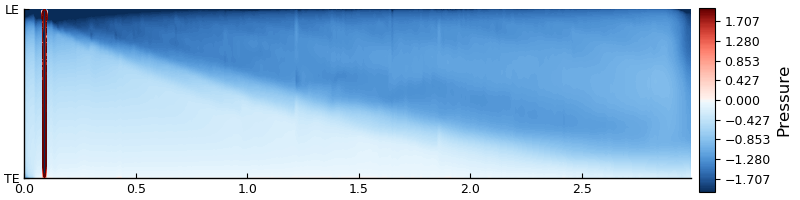

In [49]:
let s = [-0.5config.L*cos(θ) for θ in range(0.0, stop = π, length = config.N)][pressure_taps],
    model_pressures = hcat((measure_state(states[i+1][1], t, config, pressure_taps) for (i,t) in enumerate(T[1:300]))...),
#     cfd_pressures = hcat((cfd_pressure(t, pressure_taps, config, pressure_data) for t in T)...)
    
    plt = plot(size = (800, 200))
    contourf!(T[1:300], s, model_pressures,
        levels = range(-2.0, stop = 2.0, length = 151), clims = (-2, 2), color = cgrad(reverse(colormap("RdBu"))), xlabel = ["" "Convective Time"],
        yticks = ([0.5, -0.5], ["LE", "TE"]), background_color_inside = colormap("RdBu")[end], colorbar_title="Pressure")
end
#savefig("EnKF\ Results/Ensemble/pressure_n$(lpad(n,2,0)).pdf")